In [271]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.linalg import svd as SVD
from sklearn.decomposition import LatentDirichletAllocation as LDA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import precision_score, accuracy_score, recall_score,\
confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
%matplotlib inline

In [18]:
reviews = pd.read_csv('../data/yelp.csv', index_col=0)
reviews.drop('business_neighborhoods', axis=1, inplace=True)
reviews = reviews[reviews['business_categories'].str.contains('Restaurant') == True]
no_rev = reviews[pd.isna(reviews['text']) == True].index 
reviews.drop(labels=no_rev, axis=0, inplace=True)
reviews = reviews.reset_index().drop('index', axis=1)

In [19]:
#im going to group 1-2 reatings and 4-5 ratings together
reviews['stars'] = reviews['stars'].apply(lambda x: 1 if x <= 2 else x)
reviews['stars'] = reviews['stars'].apply(lambda x : 2 if x == 3 else x)
reviews['stars'] = reviews['stars'].apply(lambda x: 3 if x >=4 else x)

#classification labels: 1 if rating <=2, 2 if rating == 3, 3 if rating >= 4

In [20]:
reviews['stars']

0         3
1         3
2         3
3         3
4         3
         ..
158419    1
158420    1
158421    1
158422    3
158423    2
Name: stars, Length: 158424, dtype: int64

In [212]:
def vectorize(df ,column, method='tfidf'):
        #takes in name of column to be cleaned, and method to vectorize
        lem = WordNetLemmatizer()
        #lemmatizing as opposed to stemming 
        s_words = stopwords.words('english')
        texts = []
        for doc in df[column].values:
            cleaned = [lem.lemmatize(word).lower() for word in doc.split(' ') \
                       if word not in s_words and word.isalpha() == True]
            #making sure that every word onl
            texts.append(' '.join(cleaned))
  
        if method == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(texts).toarray()
            return vectorized
            #creating a feature names attribute(bag of words)
        elif method == 'count':
            vectorizer = CountVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(texts).toarray()
            return vectorized
def calc_scores(y_true, y_predict):
    precision = precision_score(y_true, y_predict,average='micro')
    accuracy = accuracy_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict, average='micro')
    print(f'Precision : {precision} \n'  
          f'Accuracy : {accuracy} \n'
         f'Recall: {recall}')
    return [precision, accuracy, recall]

(0.0, 4.0)

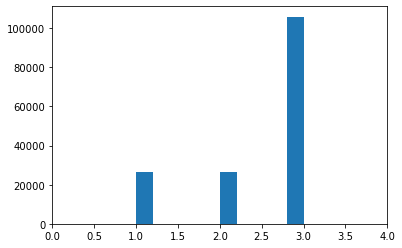

In [21]:
fig, ax = plt.subplots()
ax.hist(reviews['stars'], )
ax.set_xlim(0,4)

In [76]:
df_train, df_holdout = train_test_split(reviews)

In [77]:
len(df_train), len(df_holdout)

(118818, 39606)

In [78]:
train_total = len(df_train)

train_class_a = len(df_train[df_train.stars ==1])
train_class_b = len(df_train[df_train.stars == 2])
train_class_c = len(df_train[df_train.stars == 3])
train_class_a, train_class_b, train_class_c, train_total

(19698, 19678, 79442, 118818)

In [79]:
samp_pct = train_class_a / train_class_c
samp_num = samp_pct * train_class_c

In [80]:
samp_num

19698.0

In [59]:
train_class_a

19717

In [66]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
           )

In [82]:
df_train = downsample(df_train, 'stars')

In [257]:
def check_class_balance(df, column, labels):
    total = len(df)
    classes = {'total':total}
    for i, label in enumerate(labels):
        classes[label] = len(df[df[column] == label])
    return classes

In [258]:
check_class_balance(df_train, 'stars', [1, 2, 3])

{'total': 59034, 1: 19678, 2: 19678, 3: 19678}

In [83]:
#checking to see class balanced
train_total = len(df_train)
train_class_a = len(df_train[df_train.stars ==1])
train_class_b = len(df_train[df_train.stars == 2])
train_class_c = len(df_train[df_train.stars == 3])
train_class_a, train_class_b, train_class_c, train_total

(19678, 19678, 19678, 59034)

In [85]:
#now i can split into X and y and vectorize 
X = vectorize(df_train, 'text')
y = df_train['stars'].values

In [106]:
X_holdout = vectorize(df_holdout, 'text')
y_holdout = df_holdout['stars'].values

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [87]:
baseline_y = []
for i in range(len(y)):
    baseline_y.append(np.random.choice([1, 2, 3]))


In [88]:
baseline_scores = scores(baseline_y, y)

Precision : 0.33434969678490356 
Accuracy : 0.3343496967849036 
Recall: 0.33435393846553163


In [94]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
log_model = LogisticRegression().fit(X_train, y_train)
log_hat = log_model.predict(X_test)


In [118]:
log_test_scores = scores(y_test, log_hat)

Precision : 0.6557526341989429 
Accuracy : 0.6581069178128599 
Recall: 0.6585519455143973


In [107]:
final_log_hat = log_model.predict(X_holdout)
final_log_scores = scores(y_holdout, final_log_hat)


Precision : 0.35151617252061773 
Accuracy : 0.32467302933898906 
Recall: 0.3586035770596762


In [97]:
rm_model = RandomForestClassifier(max_samples=.5).fit(X_train, y_train)

In [141]:
rm_hat = rm_model.predict(X_test)
rm_test_scores = scores(y_test, rm_hat)

Precision : 0.601446622465564 
Accuracy : 0.6052578087946338 
Recall: 0.6057401528144193


In [108]:
final_rm_hat = rm_model.predict(X_holdout)
final_rm_scores = scores(y_holdout, final_rm_hat)

Precision : 0.34218273648352054 
Accuracy : 0.310660001009948 
Recall: 0.3564216268450105


In [101]:
gb_model = GradientBoostingClassifier().fit(X_train, y_train)

In [102]:
pickle.dump(gb_model, open('gb_model.pkl', 'wb'))

In [143]:
gb_hat = gb_model.predict(X_test)
gb_test_scores = scores(y_test, gb_hat)

Precision : 0.5978838049919876 
Accuracy : 0.5984822819974253 
Recall: 0.5987978263997074


In [119]:
# final_gb_hat = gb_model.predict(X_holdout)
final_gb_scores = scores(y_holdout, final_gb_hat)

Precision : 0.3480618214795866 
Accuracy : 0.22483967075695602 
Recall: 0.34131311897819044


In [139]:
y_test

array([3, 2, 2, ..., 2, 1, 1])

In [121]:
gb_model.predict_proba(X_test)

array([[0.24692458, 0.50321515, 0.24986027],
       [0.17147684, 0.38870036, 0.4398228 ],
       [0.39423642, 0.43939234, 0.16637124],
       ...,
       [0.20907071, 0.40593391, 0.38499538],
       [0.38824536, 0.42930006, 0.18245458],
       [0.34480942, 0.37024293, 0.28494765]])

In [137]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
#     ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
#     ax.set_xlim(xmin=0,xmax=1)
#     ax.set_ylim(ymin=0,ymax=1)

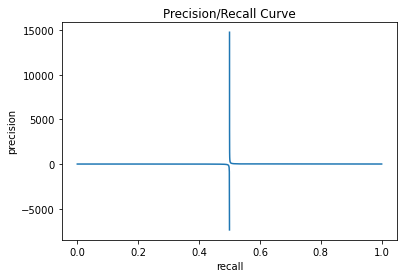

In [167]:
good_review_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 0], y_test)
fig, ax = plt.subplots()
plot_precision_recall(ax, good_review_df)

In [171]:
confusion_matrix(y_holdout, final_rm_hat)
#lots of false negatives(predicted bad review but actual good reviews)

array([[ 4428,   726,  1453],
       [ 4055,   885,  1645],
       [14898,  4525,  6991]])

In [168]:
confusion_matrix(y_holdout, final_gb_hat)
#lots of false negatives here too

array([[ 5739,   292,   576],
       [ 5592,   311,   682],
       [22435,  1124,  2855]])

In [146]:
scores = pd.DataFrame({'Baseline': baseline_scores,
                    'Logistic Test':log_test_scores,
                      'Logistic Final':final_log_scores,
                      'Random Forest Test': rm_test_scores,
                      'Random Forest Final': final_rm_scores,
                      'Gradient Boosting Test': gb_test_scores,
                      'Gradient Boosting Final':final_gb_scores},
                     index=['Precision', 'Accuracy', 'Recall'])

In [169]:
scores

,Baseline,Logistic Test,Logistic Final,Random Forest Test,Random Forest Final,Gradient Boosting Test,Gradient Boosting Final
Precision,0.334350,0.655753,0.351516,0.601447,0.342183,0.597884,0.348062
Accuracy,0.334350,0.658107,0.324673,0.605258,0.310660,0.598482,0.224840
Recall,0.334354,0.658552,0.358604,0.605740,0.356422,0.598798,0.341313


In [173]:
#okay going to try LSTM next 
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 75396 unique tokens.


In [175]:
X_lstm = tokenizer.texts_to_sequences(df_train['text'].values)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_lstm.shape)

Shape of data tensor: (59034, 250)


In [179]:

Y_lstm = pd.get_dummies(df_train['stars']).values
print('Shape of label tensor:', Y_lstm.shape)

Shape of label tensor: (59034, 3)


In [181]:
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, Y_lstm)

In [188]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [189]:
epochs = 5
batch_size = 64

history = model.fit(X_lstm_train, y_lstm_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
623/623 [==============================] - 674s 1s/step - loss: 0.8884 - accuracy: 0.5528 - val_loss: 0.6981 - val_accuracy: 0.6920
Epoch 2/5
623/623 [==============================] - 804s 1s/step - loss: 0.5980 - accuracy: 0.7416 - val_loss: 0.6608 - val_accuracy: 0.7166
Epoch 3/5
623/623 [==============================] - 844s 1s/step - loss: 0.4701 - accuracy: 0.8112 - val_loss: 0.6889 - val_accuracy: 0.7037
Epoch 4/5
623/623 [==============================] - 867s 1s/step - loss: 0.3958 - accuracy: 0.8427 - val_loss: 0.7603 - val_accuracy: 0.6935
Epoch 5/5
623/623 [==============================] - 1134s 2s/step - loss: 0.3262 - accuracy: 0.8760 - val_loss: 0.8409 - val_accuracy: 0.7010


In [192]:
history.history

{'loss': [0.7820824384689331,
  0.5954062938690186,
  0.48573553562164307,
  0.4104870855808258,
  0.34112057089805603],
 'accuracy': [0.6313900947570801,
  0.7445479035377502,
  0.8014405369758606,
  0.8359224200248718,
  0.8692247867584229],
 'val_loss': [0.6980506777763367,
  0.6607984900474548,
  0.6888737082481384,
  0.76025390625,
  0.8408969640731812],
 'val_accuracy': [0.6919602751731873,
  0.716576337814331,
  0.7037037014961243,
  0.6935411095619202,
  0.7009936571121216]}

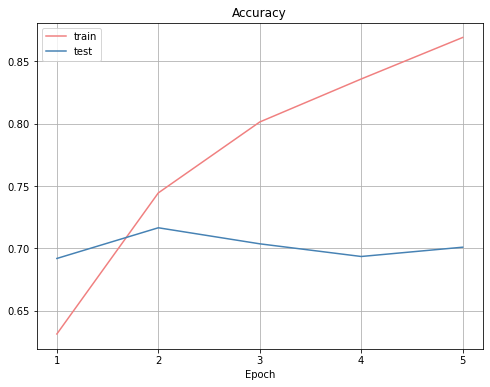

In [272]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Accuracy')
ax.plot(history.history['accuracy'], label='train', color='lightcoral')
ax.plot(history.history['val_accuracy'], label='test', color='steelblue')
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(5))
ax.set_xticklabels(np.arange(1, 6))
ax.legend()
ax.grid()
plt.savefig('../img/accr.png');

In [203]:
model.evaluate(X_lstm_test, y_lstm_test)

462/462 [==============================] - 67s 145ms/step - loss: 0.8294 - accuracy: 0.6983


[0.8294102549552917, 0.6982858180999756]

In [243]:
#function to generate hard classified labels 
def hard(soft_hat):
    hard_hat = []
    for row in soft_hat:
        cls = int(np.where(row == np.max(row))[0]) + 1
        hard_hat.append(cls)
    hard_hat = np.array(hard_hat)
    return hard_hat

In [245]:
y_lstm_test_hat = hard(model.predict(X_lstm_test))
y_lstm_test_hat

array([2, 1, 2, ..., 1, 2, 3])

In [247]:
lstm_test_scores = calc_scores(hard(y_lstm_test), y_lstm_test_hat)

Precision : 0.6962905776560707 
Accuracy : 0.6982857917203062 
Recall: 0.6994775911120859


In [207]:
#going to try on holdout(unbalanced)
X_lstm_holdout = tokenizer.texts_to_sequences(df_holdout['text'].values)
X_lstm_holdout = pad_sequences(X_lstm_holdout, maxlen=MAX_SEQUENCE_LENGTH)
y_lstm_holdout = pd.get_dummies(df_holdout['stars']).values

In [208]:
model.evaluate(X_lstm_holdout, y_lstm_holdout)

1238/1238 [==============================] - 112s 90ms/step - loss: 0.7830 - accuracy: 0.7262


[0.7829727530479431, 0.7261525988578796]

In [210]:
y_lstm_hat = model.predict(X_lstm_holdout)

In [230]:
y_lstm_hat [2]

array([0.00212212, 0.00643007, 0.9914478 ], dtype=float32)

In [233]:
type(int(np.where(y_lstm_hat[2] == np.max(y_lstm_hat[2]))[0]))

int

In [238]:
y_lstm_hard_hat = []
for row in y_lstm_hat:
    cl = int(np.where(row == np.max(row))[0]) + 1
    y_lstm_hard_hat.append(cl)
y_lstm_hard_hat = np.array(y_lstm_hard_hat)

In [239]:
lstm_scores = calc_scores(y_lstm_holdout_hard, y_lstm_hard_hat)

Precision : 0.6457388522394646 
Accuracy : 0.7261526031409382 
Recall: 0.6972698858849062


In [224]:
y_lstm_holdout_hard = df_holdout['stars'].values

In [237]:
y_lstm_hat[0]

array([0.86576855, 0.13327396, 0.00095757], dtype=float32)

In [249]:
scores['LSTM Test'] = lstm_test_scores
scores['LSTM Final'] = lstm_scores

In [254]:
dfi.export(scores, '../img/results.png')

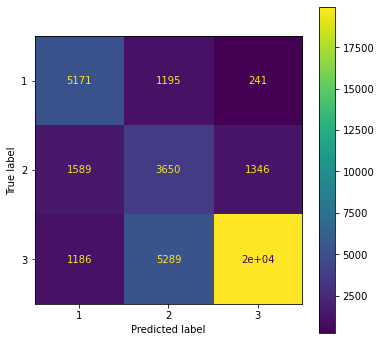

In [276]:
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix = confusion_matrix(y_lstm_holdout_hard, y_lstm_hard_hat)
cfm = ConfusionMatrixDisplay(conf_matrix, display_labels=[1,2,3]).plot(ax=ax)
plt.savefig('../img/conf-matrix.png')

In [280]:
scores

,Baseline,Logistic Test,Logistic Final,Random Forest Test,Random Forest Final,Gradient Boosting Test,Gradient Boosting Final,LSTM Test,LSTM Final
Precision,0.334350,0.655753,0.351516,0.601447,0.342183,0.597884,0.348062,0.696291,0.645739
Accuracy,0.334350,0.658107,0.324673,0.605258,0.310660,0.598482,0.224840,0.698286,0.726153
Recall,0.334354,0.658552,0.358604,0.605740,0.356422,0.598798,0.341313,0.699478,0.697270
